# Intro
La idea es entrenar un modelo de ml para luego registrarlo con MLFlow, por lo que en el notebook se realizará el proceso que después lo implantaremos mediante scripts

In [1]:
# Librerías

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de ml
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

# Métricas para modelos de ml
from sklearn.metrics import (confusion_matrix,
                            accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score,
                            classification_report)

from sklearn.model_selection import GridSearchCV

import joblib

In [4]:
from helper import BaseLogger

ImportError: cannot import name 'BaseLogger' from 'helper' (/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/helper/__init__.py)

In [2]:
# Leemos los datos
df = pd.read_csv('../data/raw/titanic.csv')

In [3]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [14]:
df.loc[:,"who"].unique()

array(['man', 'woman', 'child'], dtype=object)

# Análisis descriptivo
En esta sección vamos a indagar el dataset para entenderlo

In [4]:
columnas = df.columns
len_columnas = len(columnas)

print(f'las columnas son: \n {columnas}')
print(f"el número de columnas es --> {len_columnas}")

las columnas son: 
 Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')
el número de columnas es --> 15


In [5]:
# En esta celda vemos los tipos de columnas que hay. Vemos que tenemos 6 de tipo numérico y el resto son strings o booleanos
# Aquí vemos una aproximación de los nulos. Vemos que la columna deck es la que más nulos tiene y la columna age tiene unos cuantos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [6]:
'''
Aquí tenemos un describe de las variables métricas. Algunas como la variable survived o pclass no tiene sentido analizarlas aquí, ya que aunque tengan números en sus
valores, son de origen categórico. La única que podemos tratar como métrica sería la edad. Vemos que el mínimo es 0.42 años, y el máximo es 80 años. El mínimo es algo
extraño, así que trataremos a continuación a ver qué significa. La media es de 29 años, y difiere un poco de la mediana.
'''
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
'''
Aquí tenemos un descriptivo de las variables categóricas. Podemos ver el número de categorías por el que se compone y cuál es la más frecuente y cuanto aparece. En
este sentido, la que más nos interesa es la de alive, que será nuestra variable objetivo, y vemos que está algo desbalanceada, con lo que lo tendremos en cuenta.
'''
df.describe(include="object")

,sex,embarked,class,who,deck,embark_town,alive
count,891,889,891,891,203,889,891
unique,2,3,3,3,7,3,2
top,male,S,Third,man,C,Southampton,no
freq,577,644,491,537,59,644,549


In [37]:
# Veamos si tenemos filas duplicadas
'''
Podemos que tenemos 107 filas duplicadas. Habría que estudiar si realmente son duplicadas o se da por una
coincidencia. En este caso, procederemos a eliminarlas directamente por simplicidad
'''
df[df.duplicated()]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
47,1,3,female,NaN,0,0,7.7500,Q,Third,woman,False,NaN,Queenstown,yes,True
76,0,3,male,NaN,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
77,0,3,male,NaN,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
87,0,3,male,NaN,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
95,0,3,male,NaN,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,0,3,male,26.0,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
877,0,3,male,19.0,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
878,0,3,male,NaN,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
884,0,3,male,25.0,0,0,7.0500,S,Third,man,True,NaN,Southampton,no,True


In [38]:
# Eliminamos las filas duplicadas
df = df.drop_duplicates()

# Gráficos
En esta sección, lo que haremos será graficar los datos para ver con más claridad algún patrón que nos de una pista.

/tmp/ipykernel_21012/950592769.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:,"age"])


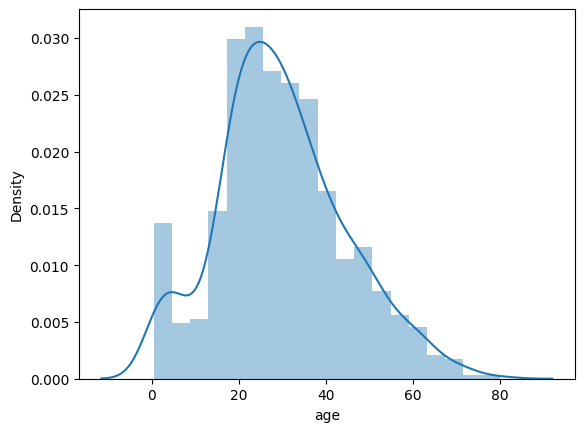

In [39]:
####### Gráfico variable métrica #######
'''
Aquí vemos un poco lo que hemos comentado anteriormente, vemos donde cae la mediana y un poco los mínimos y máximos. También vemos la figura que dibuja la distribución,
con una cola hacia la derecha, esto nos dice que quizás tengamos que normalizar esta variable para obtener mejores resultados
'''
sns.distplot(df.loc[:,"age"])
plt.show()

'\nEn los gráficos vemos también ciertos aspectos a tener en cuenta, por ejemplo que hay más homvbres que mujeres.\nTendremos que ver si el sexo influye en la variable objetivo, que en este caso es si sobreviven o no. En el resto\nde variables también vemos que hay clases más numerosas que otras. En la variable objetivo vemos un cierto desbalanceo\nque como hemos mencionado, veremos cuando entrenemos los modelos si es preciso tratarlo o no.\n'

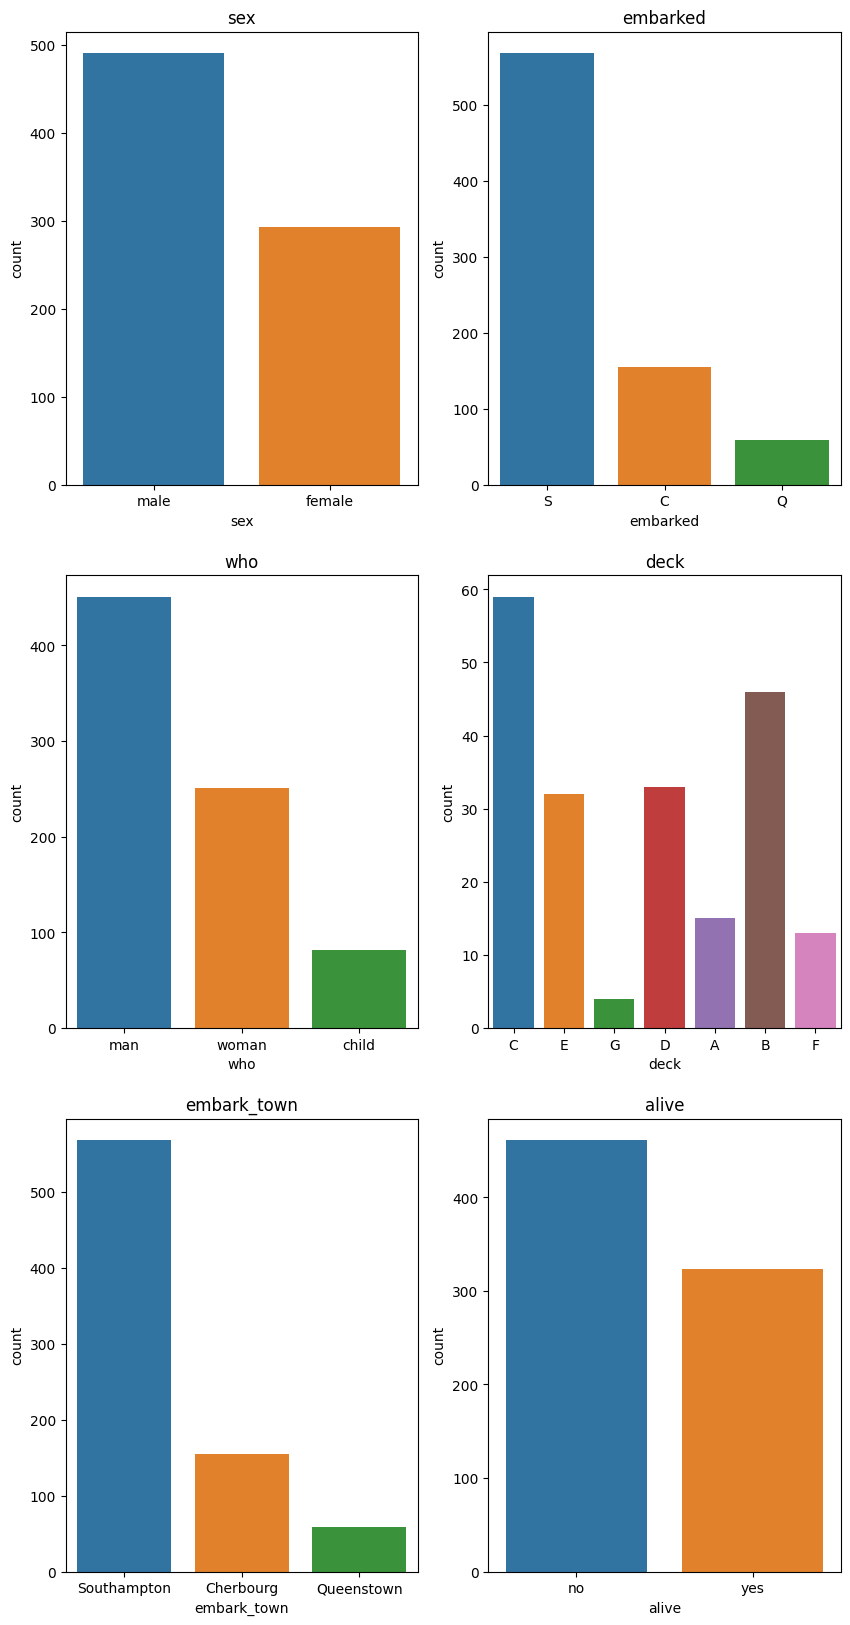

In [40]:
# Graficamos las variables métricas
plt.figure(figsize=(10, 20))

plt.subplot(3, 2, 1)
sns.countplot(x='sex', data=df)
plt.title('sex')

plt.subplot(3, 2, 2)
sns.countplot(x='embarked', data=df)
plt.title('embarked')

plt.subplot(3, 2, 3)
sns.countplot(x='who', data=df)
plt.title('who')

plt.subplot(3, 2, 4)
sns.countplot(x='deck', data=df)
plt.title('deck')

plt.subplot(3, 2, 5)
sns.countplot(x='embark_town', data=df)
plt.title('embark_town')

plt.subplot(3, 2, 6)
sns.countplot(x='alive', data=df)
plt.title('alive')

'''
En los gráficos vemos también ciertos aspectos a tener en cuenta, por ejemplo que hay más homvbres que mujeres.
Tendremos que ver si el sexo influye en la variable objetivo, que en este caso es si sobreviven o no. En el resto
de variables también vemos que hay clases más numerosas que otras. En la variable objetivo vemos un cierto desbalanceo
que como hemos mencionado, veremos cuando entrenemos los modelos si es preciso tratarlo o no.
'''

/tmp/ipykernel_21012/2198166513.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df["sex"] == "male"].age, kde_kws={"color": "b", "lw": 2, "label": "male"})
/tmp/ipykernel_21012/2198166513.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df["sex"] == "female"].age, kde_kws={"

<AxesSubplot: xlabel='age', ylabel='Density'>

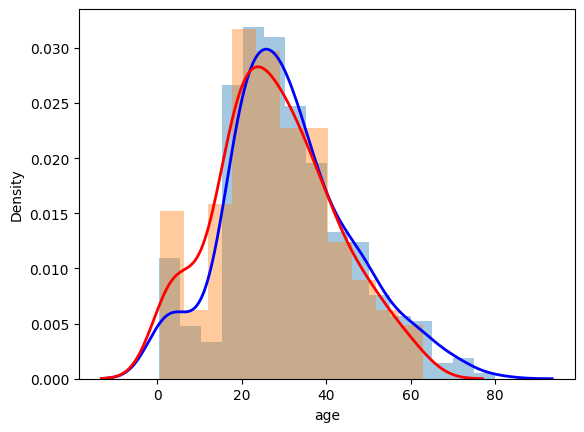

In [48]:
### Gráfico para ver la distribución de las edades según la columna sex
# Vemos que la distribución de la edad no difiere mucho en relación al sexo.
sns.distplot(df.loc[df["sex"] == "male"].age, kde_kws={"color": "b", "lw": 2, "label": "male"})
sns.distplot(df.loc[df["sex"] == "female"].age, kde_kws={"color": "r", "lw": 2, "label": "female"})

/tmp/ipykernel_21012/3926500996.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df["alive"] == "no"].age, kde_kws={"color": "b", "lw": 2, "label": "alive = no"})
/tmp/ipykernel_21012/3926500996.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df["alive"] == "yes"].age, kde_k

<AxesSubplot: xlabel='age', ylabel='Density'>

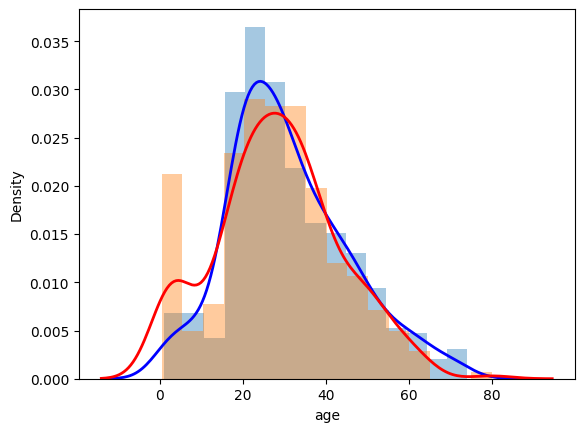

In [49]:
### Gráfico para ver la distribución de las edades según la columna alive
'''
En este gráfico podemos observar que los que no sobreviven (azul) tienen un pico en su distribución de la edad
más significativo que los que sobreviven. Esto se debe a que los que sobreviven se distribuyen tambien en unas edades
más tempranas.
'''
sns.distplot(df.loc[df["alive"] == "no"].age, kde_kws={"color": "b", "lw": 2, "label": "alive = no"})
sns.distplot(df.loc[df["alive"] == "yes"].age, kde_kws={"color": "r", "lw": 2, "label": "alive = yes"})

# Feature selection
Ya hemos visto qué variables influyen más, así que procederemos a seleccionar variables que nos interese

In [51]:
columns_X = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked", "class", "who", "embark_town", "alone"]
columns_y = ["survived"]

df_X = df.loc[:, columns_X]
df_y = df.loc[:, columns_y]

# Tratamos las variables métricas

In [52]:
# Seleccionamos las variables métricas
numeric = df_X.loc[:,["age", "fare"]]

In [53]:
# Vemos los nans de las numéricas
numeric.isnull().sum()

age     106
fare      0
dtype: int64

In [54]:
# Imputamos los valores de la edad
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
matrix_numeric = imputer.fit_transform(numeric)

numeric_not_null = pd.DataFrame(matrix_numeric, columns = numeric.columns)

numeric_not_null.isnull().sum()

In [55]:
# Estandarizamos las variables numéricas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
matrix_standar = scaler.fit_transform(numeric_not_null)

df_num_scaled = pd.DataFrame(matrix_standar, columns=numeric_not_null.columns)

In [56]:
df_num_scaled.head()

,age,fare
0,-0.573777,-0.526825
1,0.592829,0.701587
2,-0.282126,-0.513876
3,0.374091,0.352760
4,0.374091,-0.511478


# Tratamos variables categóricas

In [57]:
categor = df_X.drop(numeric.columns, axis=1)

In [58]:
# Tratamos los nulos
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

matrix_cat = imputer.fit_transform(categor)
cat_not_null = pd.DataFrame(matrix_cat, columns=categor.columns)

In [59]:
# Hacemos dummies para que lo entienda el modelo
cat_clean = pd.get_dummies(cat_not_null)

/tmp/ipykernel_21012/2204880212.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat_clean = pd.get_dummies(cat_not_null)
/tmp/ipykernel_21012/2204880212.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat_clean = pd.get_dummies(cat_not_null)
/tmp/ipykernel_21012/2204880212.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat_clean = pd.get_dummies(cat_not_null)


# Unimos los 2 dataframe

In [60]:
df_clean = pd.concat([df_num_scaled, cat_clean], axis=1)

# Separamos en train y test

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_clean, df_y, test_size = 0.1)

# Entrenamos el modelo

## Regresión logística

In [40]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [42]:
# Evaluamos el resultado
yhat = lr.predict(X_test)

______________________________________________________________________
accuracy => 0.8444444444444444
______________________________________________________________________
precission => 0.6944444444444444
______________________________________________________________________
recall => 0.8928571428571429
______________________________________________________________________
f1 => 0.78125


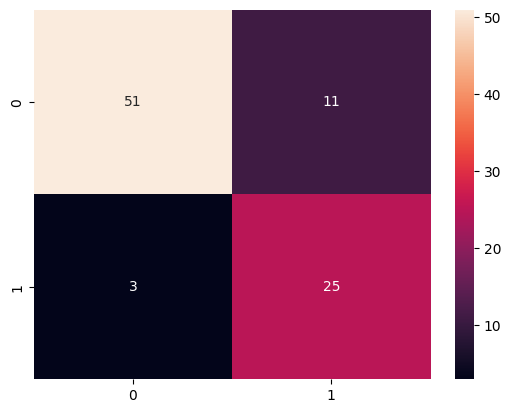

In [45]:
# PLoteamos la matriz de confusión de los datos
sns.heatmap(confusion_matrix(y_test, yhat), annot=True)
print("_______" *10)
print(f'accuracy => {accuracy_score(y_test, yhat)}')
print("_______" *10)
print(f'precission => {precision_score(y_test, yhat)}')
print("_______" *10)
print(f'recall => {recall_score(y_test, yhat)}')
print("_______" *10)
print(f'f1 => {f1_score(y_test, yhat)}')

# Random forest

In [62]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
yhat = rf.predict(X_test)

/tmp/ipykernel_21012/2941914523.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)


______________________________________________________________________
accuracy => 0.7721518987341772
______________________________________________________________________
precission => 0.7
______________________________________________________________________
recall => 0.7
______________________________________________________________________
f1 => 0.7


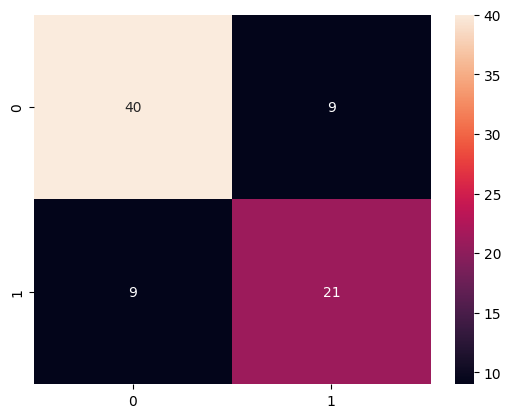

In [63]:
# PLoteamos la matriz de confusión de los datos

sns.heatmap(confusion_matrix(y_test, yhat), annot=True)
print("_______" *10)
print(f'accuracy => {accuracy_score(y_test, yhat)}')
print("_______" *10)
print(f'precission => {precision_score(y_test, yhat)}')
print("_______" *10)
print(f'recall => {recall_score(y_test, yhat)}')
print("_______" *10)
print(f'f1 => {f1_score(y_test, yhat)}')

# Gridsearch
En este apartado vamos a utilizar una prueba muy útil para entrenar todos los modelos que consideremos de una vez y seleccionar el que más nos convenga.

In [99]:
models = {'svm' : {'model' : svm.SVC(gamma = 'auto'),
                  'params': {'C' : [1,10,20,30],
                             'kernel' : ['rbf', 'linear', 'poly']}},
         'lr' : {'model' : LogisticRegression(solver = 'liblinear'),
                 'params' : {'C' : [1, 2, 3, 4],
                             'penalty' : ['l1','l2']}},
         'rf' : {'model' : RandomForestClassifier(),
                 'params' : {'n_estimators' : [1,5,20,30]}}
        }

In [100]:
list(np.arange(1,5))

[1, 2, 3, 4]

In [101]:
scores = list()

for model, mp in models.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score = False)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : model,
        'best_score' : clf.best_score_,
        'best_params': clf.best_params_
    })

/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A 

/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A 

/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A 

/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/s

# Conclusiones
Vemos que el mejor modelo es la máquina de soporte vectorial, seguido por la regresión logística muy de cerca. Aunque todos los modelos podemos asumir que tienen buenos resultados.

A la hora de enfrentarnos a un caso real, la elección del modelo dependería de muchas variables, por ejemplo, el modelo svm es un modelo pesado y que no suele funcionar bien si hay muchos datos y muchas columnas, ya que se incrementa su complegidad al haber demasiadas dimensiones, por lo que aunque sea el que mejor score tiene, se elegiría la regresión logística al ser un modelo más liviano.

Es por eso que cogeremos la regresión logística como modelo para este ejercicio, ya que se obtienen buenos resultados y además no es tan complejo como el modelo svm.

In [104]:
df_scores = pd.DataFrame(scores)
df_scores

,model,best_score,best_params
0,svm,0.798582,"{'C': 20, 'kernel': 'poly'}"
1,lr,0.790071,"{'C': 3, 'penalty': 'l1'}"
2,rf,0.781560,{'n_estimators': 20}


# Entrenamos el modelo definitivo

In [105]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Evaluamos el resultado
yhat = lr.predict(X_test)

/home/nalaminos/Entornos/mlops-titanic/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


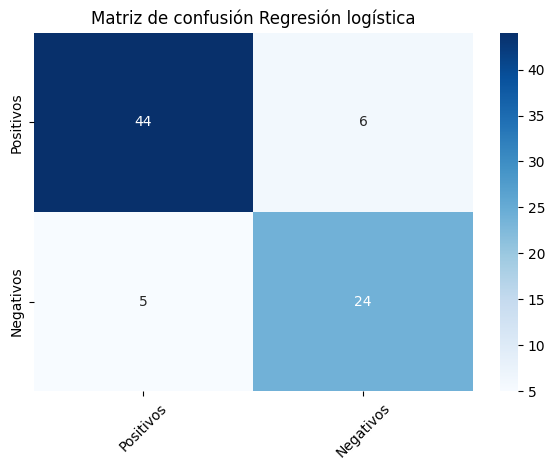

********************
accuracy = 0.8607594936708861
********************
precission = 0.8
********************
recall = 0.8275862068965517
********************
f1 score = 0.8135593220338982
********************
reporte:                precision    recall  f1-score   support

           0       0.90      0.88      0.89        50
           1       0.80      0.83      0.81        29

    accuracy                           0.86        79
   macro avg       0.85      0.85      0.85        79
weighted avg       0.86      0.86      0.86        79



In [111]:
plt.title('Matriz de confusión Regresión logística')
labels = ['Positivos', 'Negativos']
marcas = np.arange(len(labels))
plt.xticks(marcas, labels, rotation = 45)
plt.tight_layout()
sns.heatmap(confusion_matrix(yhat, y_test), 
            annot = True, cmap = 'Blues', 
            xticklabels=labels, yticklabels=labels)
plt.show()
print('**'*10)
print('accuracy = {}'.format(accuracy_score(yhat, y_test)))
print('**'*10)
print('precission = {}'.format(precision_score(yhat, y_test)))
print('**'*10)
print('recall = {}'.format(recall_score(yhat, y_test)))
print('**'*10)
print('f1 score = {}'.format(f1_score(yhat, y_test)))
print('**'*10)
print('reporte: ', classification_report(yhat, y_test))

# Guardamos el modelo

In [113]:
import pickle

file_name = "regresion_logistica.pkl"

pickle.dump(lr, open(file_name,'wb'))